# Predicting Crime in Denver using KNN and Linear Regression -- Kristofer Schobert

We will be using a dataset of crime in Denver, CO, USA. We hope to predict the time of a crime based on the location of that crime. To deal with the cyclical nature of time of day, we will map the times of day onto a unit circle and predict sin(time) and cos(time) for a given location in Denver. Midnight will be a zero radians 6am at pi/2 radians and so on.

As the title suggest, we will compare the predictions of a linear regression and a nearest neighbors model. 

Here is the link where the data can be found:

https://www.kaggle.com/paultimothymooney/denver-crime-data/version/33


In [1]:
import math
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression

%matplotlib inline
sns.set_style('white')

df_full = pd.read_csv('Denver_Crime.csv')
df_full.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


From this dataset we will keep the columns: 'GEO_LON', 'GEO_LAT', 'REPORTED_DATE','IS_CRIME'. We are only interested in incidents that are crimes, thus we will only keep the values where 'IS_CRIME' == 1.  

In [2]:
df = df_full[['GEO_LON', 'GEO_LAT', 'REPORTED_DATE','IS_CRIME']]
df.head()

,GEO_LON,GEO_LAT,REPORTED_DATE,IS_CRIME
0,-104.809881,39.773188,6/15/2016 11:31:00 PM,1
1,-104.781434,39.785649,1/29/2018 5:53:00 PM,1
2,-104.957381,39.663490,4/26/2016 9:02:00 PM,1
3,-104.941440,39.702698,1/30/2018 10:29:00 PM,1
4,-104.955370,39.717107,6/23/2017 4:09:00 PM,1


In [3]:
# only concidering incidents that are crime (i.e. not triffic)
df = df[df['IS_CRIME'] == 1].copy()

# splitting date and time into their own columns
df[['date', 'time', 'ampm']] = df['REPORTED_DATE'].str.split(' ', expand = True)
df = df.drop(['REPORTED_DATE', 'IS_CRIME'], axis=1)

# splitting time into hour minute and second
df[['hour', 'minute', 'second']] = df['time'].str.split(':', expand = True)
df = df.drop(['date', 'time', 'second'], axis=1)
df.hour = pd.to_numeric(df.hour)
df.minute = pd.to_numeric(df.minute)


#pd.where note: when the condition is FALSE make the modification...
#converting time to a 24 hour clock
#working with technicalities of am to pm, 12am = 0, 12pm = 12
df['24hour'] = df['hour'].where(df['ampm'] == 'AM', df['hour'] + 12)
df['24hour'] = df['24hour'].where(df['24hour'] != 12, 0)
df['24hour'] = df['24hour'].where(df['24hour'] != 24, 12)
df.head()

,GEO_LON,GEO_LAT,ampm,hour,minute,24hour
0,-104.809881,39.773188,PM,11,31,23
1,-104.781434,39.785649,PM,5,53,17
2,-104.957381,39.663490,PM,9,2,21
3,-104.941440,39.702698,PM,10,29,22
4,-104.955370,39.717107,PM,4,9,16


In [4]:
# creating a decimal time column. (i.e 30min becomes 0.5hrs)
# renaming columns to simply latitude and longitude. 

df['decimal_minute'] = df['minute']/60
df['decimal_time'] = df['24hour'] + df['decimal_minute']
df = df[['GEO_LON', 'GEO_LAT', 'decimal_time']].copy()
df = df.rename(columns={'GEO_LON':'longitude', 'GEO_LAT':'latitude'}).copy()
df.head()

,longitude,latitude,decimal_time
0,-104.809881,39.773188,23.516667
1,-104.781434,39.785649,17.883333
2,-104.957381,39.663490,21.033333
3,-104.941440,39.702698,22.483333
4,-104.955370,39.717107,16.150000


In [5]:
#creating radians_time, which is the angle which cooresponds to a certain time.
#We are mapping the 24hrs to a unit circle. 0 radians is mindight, pi/2 is 6am, pi radians is noon...
#We then take the sine and cosine of those angles. 
df['radians_time'] = df['decimal_time']*2*(np.pi)/24
df['sin_of_time'] = np.sin(df['radians_time'])
df['cos_of_time'] = np.cos(df['radians_time'])
df.head()

,longitude,latitude,decimal_time,radians_time,sin_of_time,cos_of_time
0,-104.809881,39.773188,23.516667,6.156649,-0.126199,0.992005
1,-104.781434,39.785649,17.883333,4.681846,-0.999534,-0.030539
2,-104.957381,39.663490,21.033333,5.506514,-0.700909,0.713250
3,-104.941440,39.702698,22.483333,5.886123,-0.386711,0.922201
4,-104.955370,39.717107,16.150000,4.228060,-0.884988,-0.465615


In [ ]:
#dropping Null values in long and lat
df = df.dropna().copy()
#dropping lat and long values that are not accurate (there are a handful that are [0,0])
df = df[df['latitude'] > 30].copy()

## Predicing sin_of_time with OLS fit

In [7]:
#predicing sin_of_time with OLS fit
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['sin_of_time']
X = df[['longitude','latitude']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

y_pred = regr.predict(X)

from sklearn.model_selection import cross_val_score
cross_score = cross_val_score(regr, X, Y, cv=10)
print('\n' + str(cross_score))
print("\n Unweighted Accuracy: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))


Coefficients: 
 [-0.03035824 -0.09149066]

Intercept: 
 0.25262239549033516

R-squared:
5.279438157967942e-05

[ 1.43613887e-04 -9.03695840e-05 -2.47438583e-04 -2.44370186e-04
 -4.98113732e-04  9.17103766e-05  9.36659890e-05 -6.33004993e-05
 -2.43933833e-04  2.16388870e-05]

 Unweighted Accuracy: -0.00010 (+/- 0.00039)


Well our model has an R^2 value of nearly zero. Thus our model is just as accurate at predicting the average value of sin_of_time for each location. Our coefficients values are nearly zero. This indicates that our linear regression's plane of prediction is nearly flat (normal vector pointing in the z-direction). Our cross validation shows that or model is concistant for different test values. 

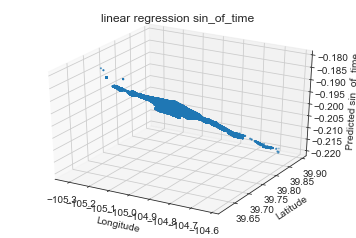

In [9]:
# 3D Plot of OLS values
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.values[:,0], X.values[:,1], y_pred, s=1)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Predicted sin_of_time')
plt.title('linear regression sin_of_time')
 
plt.show()

Here we see the plane of prediction from our linear regression. The plane appears to have some slope, but still it's range is roughly 0.04. Does this indicate a small change in time? Well time is proportional to the angle of sine, thus we need to take the arcsin of these values to determine the range in angles we have. Also, it is worth noting that sine and arcsin are not linear functions. Thus, a change in sin_of_time of 0.04 could result in a large or small change in arcsin_of_time depending on the values of sin_of_time. 

In [318]:
#The range of predicted times:
(np.arcsin(-.22) - np.arcsin(-.18))*24/(2*np.pi)

-0.15595154592786784

This is a change of only roughly 15% of an hour. This is not much. Indeed, our plane is very flat. 

## Nearest Neighbors Model for sin_of_time

In [311]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=100)
X = pd.DataFrame([df.latitude, df.longitude]).T
Y = df.sin_of_time
knn.fit(X, Y)

y_pred = knn.predict(X)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

#pd.DataFrame([knn.predict(X),X.values,Y]).T
#print(np.array(Y))

[0.02652463 0.03153717 0.04081783 0.03505372 0.03062541 0.03542001
 0.04080266 0.03320486 0.03235152 0.01929553]
Accuracy: 0.03 (+/- 0.01)


Much like our regression for sin_of_time. Our KNN model is consitant, and it is roughly as accurate as prediction the mean value of sin_of_time each iteration. We know this because our cross validation shows that our model earns a R^2 score of roughly zero regradless of which data points we withhold for testing. 

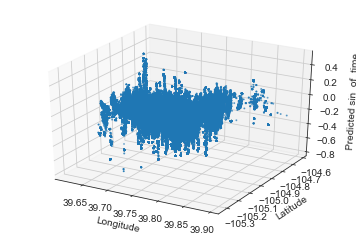

In [314]:
# 3D Plot of model's output

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.values[:,0], X.values[:,1], y_pred, s=1)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Predicted sin_of_time')
 
plt.show()

Here, we see our KNN model's output. While this is interesting to see, it is certainly difficult to tell what is going on with so many predictions for so many various input locations. Our predicted data looks to have a mean near zero. 

## OLS for cos_of_time

In [328]:
# Cosine of time
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['cos_of_time']
X = df[['longitude','latitude']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

y_pred = regr.predict(X)

from sklearn.model_selection import cross_val_score
cross_score = cross_val_score(regr, X, Y, cv=10)
print('\n' + str(cross_score))
print("\n Unweighted Accuracy: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))


Coefficients: 
 [-0.44136507  0.35010068]

Intercept: 
 -60.337353183198466

R-squared:
0.0016199695599397046

[ 0.00045722 -0.00097456  0.00243769  0.00159848 -0.00076762 -0.00050064
  0.0014134   0.00198181  0.00203783 -0.00496623]

 Unweighted Accuracy: 0.00027 (+/- 0.00422)


First our intercept is very low here, lower than minimum possible value of cos_of_time, which is -1. This is alright. It is just a concequense of our input values being so far from the origin. Latitude is always roughly 40, and longitude is always roughly -105. Our alpha and beta values are greater than they were for the OLS regression of sin_of_time. This means our plane of predicition is less flat than our sin_of_time plane. Our R^2 value is roughly zero, again this means that predicting the output data's average value is just as accurate of a model. Our cross validation shows that our model is not overfit and is consistant with new data. 

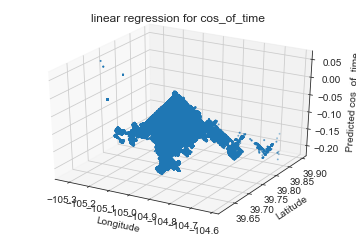

In [329]:
# 3D plot for OLS cos_of_time

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.values[:,0], X.values[:,1], y_pred, s=1)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Predicted cos_of_time')

plt.title('linear regression for cos_of_time')
 
plt.show()

Again for the linear regression, we see a plane as our output. Does this coorespond to a large range of times? The max output seems to be around 0 where the minimum looks to be around -0.2. Let's see. 

In [333]:
#The range of predicted times:
(np.arccos(-0.2) - np.arccos(0))*24/(2*np.pi)

0.7691306021876996

This cooresponds to roughly 45 minutes. This is not a very large range. Our plane of prediction is very flat, although not as flat as our prediction for sin_of_time.

## Nearest Neighbors Model for cos_of_time

In [325]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=100)
X = pd.DataFrame([df.latitude, df.longitude]).T
Y = df.cos_of_time
knn.fit(X, Y)

y_pred = knn.predict(X)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

#pd.DataFrame([knn.predict(X),X.values,Y]).T
#print(np.array(Y))

[0.04862901 0.05650056 0.05623717 0.06069891 0.05162202 0.06469004
 0.06281206 0.05741942 0.06123926 0.03003653]
Accuracy: 0.05 (+/- 0.02)


After trying different numbers of neighbors, Our KNN model for cos_of_time is no better and any other model we have created for predicting the time of crime per location. We have an R^2 score of zero and cross validation confirms we earn a score of roughly zero regardless of the data with withhold. 

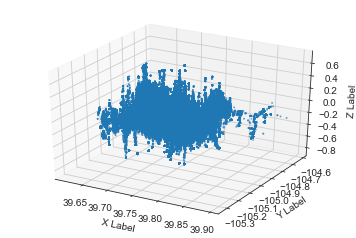

In [326]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.values[:,0], X.values[:,1], y_pred, s=1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
 
plt.show()

Above, we have the predictions for cos_of_time via our nearest neightbors model. Our predicted data looks to have a mean of zero. 

Let's take a look at what the average values for sin_of_time, cos_of_time, and decimal time are. Our models are just as accurate as predicting these values.

## Calculating the average values of our output data

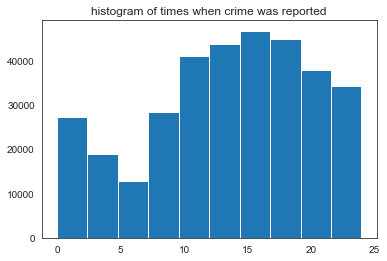

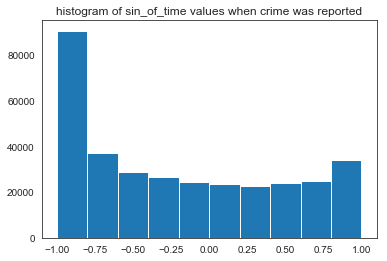

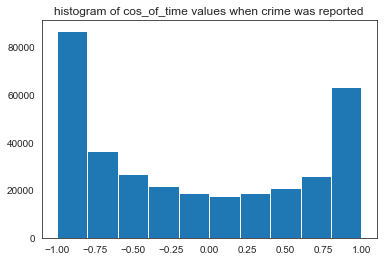

the mean value of sin_of_time is: -0.19601419065064168
the mean value of cos_of_time is: -0.09910161304065644
the mean value of tan_of_time is: 1.9779112028199466
From these average values we can calculate a mean value for the time crime is reported: 16.211971677982994


In [22]:
plt.hist(df.decimal_time)
plt.title('histogram of times when crime was reported')
plt.show()

plt.hist(df.sin_of_time)
plt.title('histogram of sin_of_time values when crime was reported')
plt.show()

plt.hist(df.cos_of_time)
plt.title('histogram of cos_of_time values when crime was reported')
plt.show()

print('the mean value of sin_of_time is: ' + str(np.mean(df.sin_of_time)))
print('the mean value of cos_of_time is: ' + str(np.mean(df.cos_of_time)))
print('the mean value of tan_of_time is: ' + str(np.mean(df.sin_of_time)/np.mean(df.cos_of_time)))
print('From these average values we can calculate a mean value for the time crime is reported: ' 
      + str(12 + np.arctan((np.mean(df.sin_of_time)/np.mean(df.cos_of_time)))*12/np.pi))



We see that overall in Denver the most common time to report crime in roughly 4PM. We see the larger values on either side of the histograms of sine and cosine of time because of the nature of the functions. For points evenly spaced around a circle, a small range in sine and cosine corresponds to many more points on a circle when the value of sine or cosine is near 1 or -1 relative to when the value of sine and cosine are zero. The mean values shown are as accurate of a prediction for a when crime will be reportated at a given location as our models. 

# Conclusion and Final Thoughts

While this was an enlightening process for me, none of our models worked well. Our models predicted the sin_of_time for each location. One sin_of_time value corresponds to two different times of day. Unfortunately, our model predictions for those two times of the day for each location was no better than predicting the average sin_of_time value for each location. The same is true for cos_of_time.

These models work best when there is a definitive trend in the data. Our data does not have a clear trend, thus our issue. 

One helpful aspect of using a KNN regression is that one simply inputs the features they believe corresponds to the output. In a linear regression on must concider what features correspond to an output and what function of the feature to use in their model. Maybe we need the feature squared or the sin of the feature or exp(-feature). This can be a bit of a guessing came even after some plot to guide one's guessing. When using KNN, one does not even need to concider this guessing game. The nearest neighbors will guide the shape of the model's output. 

If one has an obvious trend in the data, then a linear regression may be best. If one's output data is clearly in the shape of a parabolic bowl with regards to two features, then use a linear regression with both features squared. If the output is truly a parabolic bowl, then it will be an excellent fit. KNN will do alright, but the model's output will never be this exact mathematical surface. The KNN surface will be a rough imperfect shape. This is not ideal when we are dealing with a more smooth predictable phenomenon. 

Of course, there are situations where it is not clear which kind of model one should pursue. In that case, it is best to try both and see which model has a better cross validation score. 


